# Sequential Search

**Sequential Search**

Sequential Search evaluates hyperparameters one at a time in a predefined order, making it simple and easy to implement. It is inherently non-parallelizable, meaning only one hyperparameter configuration is tested at a time. This approach is best suited for simple models with a small number of hyperparameters or in scenarios where computational resources are limited. However, its linear nature may lead to missed optimal configurations and can be time-consuming as the parameter space increases.

**Non-Sequential Search (Grid Search & Random Search)**

Non-Sequential Search encompasses methods like Grid Search and Random Search, which evaluate multiple hyperparameter combinations simultaneously. Grid Search systematically explores every possible combination, ensuring a comprehensive search but can become computationally expensive with many parameters. In contrast, Random Search randomly samples from the hyperparameter space, providing a more efficient alternative, especially in high-dimensional scenarios. Both methods support parallel execution, making them suitable for complex models and larger datasets, ultimately offering a better chance of finding optimal configurations compared to Sequential Search.

# Sequential Model-Based Optimization (SMBO)
SMBO is a strategy used for optimizing black-box functions, particularly in hyperparameter tuning for machine learning models. It iteratively builds a surrogate model to approximate the objective function and uses this model to select the next point to evaluate. SMBO is efficient because it aims to minimize the number of evaluations of the expensive objective function by intelligently exploring the hyperparameter space based on previous evaluations.

# Gaussian Process

is a way for a model to make predictions about something, like how well a set of hyperparameters will perform. Instead of just guessing one answer, the GP also tells us how confident it is in that guess. It gives two things:

A mean (the best guess of the performance at a specific point, like a hyperparameter setting).
A variance (how uncertain the model is about that guess).
The more data the GP gets (e.g., the more hyperparameter combinations it tries), the better it becomes at making predictions and reducing uncertainty in areas where it has more experience.

**Bigger Mean and Variance**

High mean is generally good because it predicts good performance.
High variance means the GP is unsure about its prediction, which could be a good place to explore for finding new, better hyperparameters.

# Kernel

The kernel in a Gaussian Process is like a rule that tells the model how similar two points are. In hyperparameter tuning, this means the kernel helps the GP understand if two different sets of hyperparameters will likely have similar performance based on how close or far apart they are. If the kernel thinks two hyperparameter sets are very similar, it will predict their performance will be similar too. The kernel helps the GP make smooth predictions across the hyperparameter space.

**Common Kernels:**

* RBF (Radial Basis Function): This kernel assumes that hyperparameters closer together will have similar performance, making smooth predictions.
* Matern Kernel: A more flexible version of RBF, it handles a range of smoothness in data and works well when there are varying levels of noise.
* Polynomial Kernel: Assumes the relationship between hyperparameters is polynomial, useful in some machine learning tasks with complex interactions between variables.

# Acquisition Functions
The acquisition function is the part of Bayesian Optimization that decides where to look next. It uses the GP’s predictions (both the mean and the uncertainty) to balance two things:

* **Exploration:** Trying out hyperparameters where the GP is uncertain (to learn more).
* **Exploitation:** Trying hyperparameters where the GP thinks performance will be good (to improve the model).
The acquisition function helps choose the next hyperparameter set to test, making the optimization process more efficient by not randomly guessing but strategically selecting the next point.

**Common Acquisition Functions:**
* Expected Improvement (EI): Chooses points where it expects the most improvement over the current best-known performance.
* Probability of Improvement (PI): Selects hyperparameters that maximize the probability of improving upon the best-known result.
* Upper Confidence Bound (UCB): Picks points that offer a balance between high mean (good performance) and high variance (uncertainty).

**Summary**

* The Gaussian Process predicts both performance (mean) and uncertainty (variance) for each set of hyperparameters.
* The kernel helps the GP understand how similar or different hyperparameters are, with RBF, Matern, and Polynomial being common choices.
* The acquisition function decides which hyperparameter to test next by balancing exploration and exploitation, with Expected Improvement, Probability of Improvement, and Upper Confidence Bound being the most common.

## Additional notes

* Prior probability is the unconditional probability assigned to an event before any relevant information is taken into account.
* The posterior probability of an event, is the conditional probability that is assigned after taking into account the new evidence.
* Bayesian Optimization as a sequential optimization strategy and is usually employed to optimize expensive to evaluate functions
* Remember that we use Bayesian Optimization when we are looking to optimize functions that are costly, like those derived from neuronal networks. For a Gradient Boosting Machine trained on little data like the one in this notebook, we would probably make a better search if we carried out a Random Search.



# Bayesian Optimization


## gp_minimize Implementation
Use **gp_minimize** and the associated utilities when you need more control over the optimization process, perhaps for custom objective functions or more complex optimization scenarios.

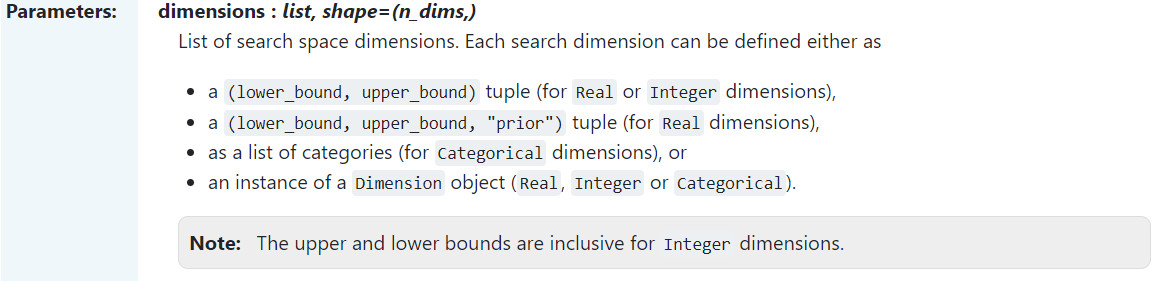

In [ ]:
# Step 1: Import necessary libraries for model, data, optimization, and plotting
from sklearn.datasets import load_breast_cancer  # Load the breast cancer dataset
from sklearn.ensemble import GradientBoostingClassifier  # Gradient Boosting Classifier for modeling
from sklearn.model_selection import cross_val_score, train_test_split  # Cross-validation and train-test split


from skopt import gp_minimize  # Bayesian optimization function to minimize the error
from skopt.plots import plot_convergence  # Plot convergence of optimization over iterations
# These classes define the possible ranges of values for different hyperparameters
from skopt.space import Real, Integer, Categorical  # Define hyperparameter spaces for tuning
# This decorator allows the objective function to use keyword arguments for hyperparameters
from skopt.utils import use_named_args  # Decorator for passing hyperparameters as named arguments

# Step 2: Set up the Gradient Boosting Classifier
# Initialize the classifier with a fixed random state for reproducibility
gbm = GradientBoostingClassifier(random_state=0)

In [ ]:
# Step 1: Design the objective function for optimization
# The function aims to maximize the accuracy of the Gradient Boosting Model (GBM) using cross-validation
@use_named_args(param_grid)  # Decorator allows the function to accept hyperparameters as keyword arguments

def objective(**params):  # Accepts hyperparameters as keyword arguments

    # Step 2: Set model parameters
    # Update the GBM model with the new hyperparameters passed to the function
    gbm.set_params(**params)

    # Step 3: Calculate the mean accuracy using cross-validation
    # Evaluate the model's performance using cross-validation with 3 folds
    value = np.mean(
        cross_val_score(
            gbm,  # The model to evaluate
            X_train,  # Training data features
            y_train,  # Training data target
            cv=3,  # Number of cross-validation folds
            n_jobs=-4,  # Use multiple jobs for faster computation
            scoring='accuracy'  # Metric used to evaluate the model
        )
    )

    # Step 4: Return the negative accuracy for minimization
    # The optimization process requires minimizing the function, hence we return the negative value
    return -value

**By default, a Matern kernel is used with the following hyperparameters tuned.**

In [ ]:
# Step 1: Perform Gaussian Process Optimization
# gp_minimize uses Gaussian Processes with a Matérn Kernel to optimize the objective function
gp_ = gp_minimize(
    objective,  # The objective function to minimize, which evaluates model accuracy
    param_grid,  # The hyperparameter space defined earlier
    n_initial_points=10,  # The number of initial points to evaluate the objective function
    acq_func='EI',  # The acquisition function used to balance exploration and exploitation
    n_calls=50,  # The total number of evaluations of the objective function
    random_state=0,  # Seed for reproducibility of results
)

# Step 2: Retrieve the function value at the minimum
# The best score is the negative of the accuracy since we are minimizing the negative accuracy
"Best score=%.4f" % gp_.fun

# Step 3: Print the best hyperparameters found during optimization
# Displays the optimal parameters that resulted in the highest accuracy
print("""Best parameters:
=========================
- n_estimators=%d
- min_samples_split=%.6f
- max_depth=%d
- loss = %s""" % (gp_.x[0],
                gp_.x[1],
                gp_.x[2],
                gp_.x[3]))

# Step 4: Plot the convergence of the optimization process
# Visualizes how the optimization process progresses towards finding the minimum
plot_convergence(gp_)

### Visualize Bayesian Optimization

In [ ]:
end = 10  # Total number of iterations for the plots

# Step 1: Iterate over a range to create multiple plots
for n_iter in range(1, end):

    # Step 2: Set up the figure size for the plots
    plt.figure(figsize=(10, 20))

    # ===================

    # Step 3: Create the left subplot for the Gaussian Process Search
    plt.subplot(end, 2, 2*n_iter + 1)

    # Step 4: Plot the Gaussian Process search results
    ax = plot_gaussian_process(
        gp_,  # The Gaussian Process object from previous optimization
        n_calls=n_iter,  # Number of calls to the objective function to show
        show_legend=True,  # Display legend on the plot
        show_title=False,  # Do not display title
        show_next_point=False,  # Do not indicate the next point to sample
        show_acq_func=False  # Do not show the acquisition function
    )

    # Step 5: Overlay the true hyperparameter response function
    ax.scatter(results['param_n_estimators'], -results['mean_test_score'])

    ax.set_ylabel("")  # Clear the y-axis label
    ax.set_xlabel("")  # Clear the x-axis label

    # ===================

    # Step 6: Create the right subplot for the Acquisition Function (EI)
    plt.subplot(end, 2, 2*n_iter + 2)

    # Step 7: Plot the Gaussian Process search with the acquisition function
    ax = plot_gaussian_process(
        gp_,  # The Gaussian Process object
        n_calls=n_iter,  # Number of calls to the objective function to show
        show_legend=True,  # Display legend on the plot
        show_title=False,  # Do not display title
        show_mu=False,  # Do not show the mean prediction
        show_acq_func=True,  # Show the acquisition function
        show_observations=False,  # Do not show previous observations
        show_next_point=True  # Show the next point to sample
    )

    ax.set_ylabel("")  # Clear the y-axis label
    ax.set_xlabel("")  # Clear the x-axis label

# Step 8: Display all the plots created
plt.show()

## BayesSearchCV Implementation

Use BayesSearchCV when you want to optimize hyperparameters in a straightforward way with minimal setup.

In [ ]:
# Step 1: Import the BayesSearchCV wrapper for Bayesian optimization
# BayesSearchCV helps automate the process of hyperparameter tuning using Bayesian optimization.
from skopt import BayesSearchCV

# Step 2: Set up the Gradient Boosting Regressor model
# Gradient Boosting Regressor is a machine learning model that builds an ensemble of decision trees to improve prediction accuracy.
gbm = GradientBoostingRegressor(random_state=0)

# Step 3: Define the hyperparameter space for tuning
# The hyperparameter space defines the ranges and options for the parameters that will be optimized during the search.
param_grid = {
    'n_estimators': (10, 120),  # Range for the number of boosting stages
    'min_samples_split': (0.001, 0.99, 'log-uniform'),  # Minimum fraction of samples required to split a node
    'max_depth': (1, 8),  # Range for the maximum depth of the trees
    'loss': ['squared_error', 'absolute_error', 'huber'],  # Types of loss functions to consider
}

# Step 4: Set up the Bayesian search for hyperparameter tuning
# This sets up the BayesSearchCV object to perform hyperparameter optimization using the specified model and parameters.
search = BayesSearchCV(
    estimator=gbm,  # The model to optimize
    search_spaces=param_grid,  # The hyperparameter space defined above
    scoring='neg_mean_squared_error',  # Evaluation metric for model performance
    cv=3,  # Number of cross-validation folds
    n_iter=50,  # Number of iterations for the search
    random_state=10,  # Seed for reproducibility
    n_jobs=4,  # Number of parallel jobs to run
    refit=True  # Refits the best model on the whole dataset
)

# Step 5: Fit the search object to the training data
# The fitting process runs the Bayesian optimization algorithm to find the best hyperparameters based on the training data.
search.fit(X_train, y_train)

# Step 6: Retrieve the best hyperparameters
# The best hyperparameters are stored in an attribute for later use.
search.best_params_

# Step 7: Retrieve the best score
# The best score from the cross-validated models is also stored for evaluation.
search.best_score_

### Convert to Dataframe

In [ ]:
# Step 8: Gather results for all evaluated models
# This retrieves the data for all hyperparameter combinations evaluated during the search.
results = pd.DataFrame(search.cv_results_)

# Step 9: Print the shape of the results DataFrame
# This provides insight into the number of models evaluated and their performance metrics.
print(results.shape)

# Step 10: Display the first few rows of the results DataFrame
# This shows a preview of the evaluated hyperparameter combinations and their corresponding scores.
results.head()

# Step 11: Order the results based on performance
# Sorting the DataFrame by mean test score helps identify the best performing models.
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

# Step 12: Reset the index of the results DataFrame
# This resets the index after sorting to maintain a clean DataFrame.
results.reset_index(drop=True, inplace=True)

# Step 13: Plot model performance with error bars
# This visualizes the mean test score with error bars representing the standard deviation for each hyperparameter combination.
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

# Step 14: Set axis labels for the plot
# Adding labels enhances the readability of the plot.
plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

# Step 15: Make predictions on training and test data
# This uses the best model found in the search to predict on both the training and test datasets.
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

# Step 16: Calculate and print the Mean Squared Error (MSE) for training predictions
# This evaluates how well the model fits the training data by calculating the MSE.
print('Train MSE: ', mean_squared_error(y_train, X_train_preds))

# Step 17: Calculate and print the Mean Squared Error (MSE) for test predictions
# This assesses the model’s performance on unseen data by calculating the MSE on the test set.
print('Test MSE: ', mean_squared_error(y_test, X_test_preds))

## Bayesian Optimisation with different Kernels

In [ ]:
# Step 1: Import necessary libraries and modules
# Importing datasets, classifiers, utilities for model evaluation, Gaussian processes, and optimization functions.
from sklearn.datasets import load_breast_cancer  # Dataset for breast cancer classification
from sklearn.ensemble import GradientBoostingClassifier  # Gradient boosting classifier model
from sklearn.model_selection import cross_val_score, train_test_split  # Cross-validation and data splitting functions

from sklearn.gaussian_process.kernels import RBF  # RBF kernel for Gaussian processes
from skopt import gp_minimize  # Gaussian process optimization function
from skopt.plots import plot_convergence  # Function to visualize convergence of optimization
from skopt.space import Real, Integer, Categorical  # Classes for defining parameter search space
from skopt.utils import use_named_args  # Decorator for using named arguments in objective functions
from skopt.learning import GaussianProcessRegressor  # Gaussian Process Regressor with customizable kernels

# Step 2: Define the hyperparameter space for optimization
# The hyperparameter space consists of the parameters to be optimized and their respective ranges.
param_grid = [
    Integer(10, 120, name="n_estimators"),  # Number of boosting stages
    Real(0, 0.999, name="min_samples_split"),  # Minimum fraction of samples required to split a node
    Integer(1, 5, name="max_depth"),  # Maximum depth of the individual trees
    Categorical(['log_loss', 'exponential'], name="loss"),  # Types of loss functions to consider
]

# Step 3: Check the type of the parameter grid
# This confirms that the hyperparameter space is defined as a list.
type(param_grid)

# Step 4: Initialize the Gradient Boosting Classifier model
# The model will be used for classification tasks based on boosting.
gbm = GradientBoostingClassifier(random_state=0)

# Step 5: Define the Gaussian Process kernel
# The RBF kernel with specified length scale is chosen for Gaussian process regression.
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))

# Step 6: Display the defined kernel
# This allows us to verify the kernel configuration before using it in the model.
kernel

# Step 7: Initialize the Gaussian Process Regressor with the specified kernel
# This sets up the regressor with the ability to normalize output and restart the optimizer.
gpr = GaussianProcessRegressor(
    kernel=kernel,  # The defined RBF kernel
    normalize_y=True,  # Normalize the target variable
    noise="gaussian",  # Specify noise type for Gaussian processes
    n_restarts_optimizer=2  # Number of restarts for the optimizer to find the best parameters
)

In [ ]:
# Step 1: Define an objective function to maximize the accuracy of a GBM
# This function will evaluate the model's performance based on the hyperparameters provided.
@use_named_args(param_grid)
def objective(**params):

    # Step 2: Set the model parameters
    # This applies the new hyperparameters to the Gradient Boosting Model.
    gbm.set_params(**params)

    # Step 3: Calculate the mean accuracy using cross-validation
    # This evaluates the model's performance by calculating the mean accuracy score over 3 folds.
    value = np.mean(
        cross_val_score(
            gbm,
            X_train,
            y_train,
            cv=3,  # Number of cross-validation folds
            n_jobs=-4,  # Use multiple cores for parallel processing
            scoring='accuracy'  # Metric for evaluation
        )
    )

    # Step 4: Return the negative of the accuracy
    # We negate the accuracy because the optimization function needs to minimize the value.
    return -value

In [ ]:
# Step 1: Perform Bayesian optimization using Gaussian process
# This function minimizes the objective function to find the best hyperparameters.
gp_ = gp_minimize(
    objective,  # The objective function to minimize
    dimensions=param_grid,  # The hyperparameter space to explore
    base_estimator=gpr,  # The Gaussian process regressor as the base estimator
    n_initial_points=5,  # The number of initial points to sample
    acq_optimizer="sampling",  # Method for optimizing the acquisition function
    random_state=42,  # For reproducibility
)

# Step 2: Extract the function value at the minimum
# This retrieves the best score found by the optimization process.
"Best score=%.4f" % gp_.fun  # Note: This is the negative of the accuracy.

# Step 3: Print the best hyperparameters found
# Displays the best hyperparameters along with the corresponding score.
print("""Best parameters:
=========================
- n_estimators=%d
- min_samples_split=%.6f
- max_depth=%d
- loss=%s""" % (gp_.x[0],
                gp_.x[1],
                gp_.x[2],
                gp_.x[3]))

# Step 4: Plot the convergence of the optimization process
# Visualizes how the optimization process progresses towards finding the minimum
plot_convergence(gp_)

## Bayesian Optimization of CNN with Scikit-Optimize

To have a better look on how to implement bayesian optimization on a simple CNN, follow this link.

* [CNN & Bayesian Opt.](https://github.com/solegalli/hyperparameter-optimization/blob/master/Section-06-Bayesian-Optimization/07-Bayesian-Optimization-CNN.ipynb)


# How to better use Bayesian Optimization

* **Initial Exploration with Simple Methods**
Grid Search: Professionals often start with grid search or random search to explore the hyperparameter space. These methods help assess the performance landscape by evaluating a range of hyperparameter values systematically. The purpose of this initial exploration is to identify if there are any clear trends or smoothness in performance changes. It can reveal whether some hyperparameters have a more predictable effect on model performance.

* **Assessing Performance**
During the grid search, professionals look for consistency in whether performance improves consistently with certain adjustments and smoothness in whether small changes in hyperparameters lead to small changes in performance. These observations inform their understanding of the model's behavior.

* **Transitioning to Advanced Methods**
Cost-Effectiveness: Once they have a good sense of the landscape from initial searches, professionals often switch to Bayesian optimization. This is because Bayesian optimization is more efficient in finding optimal hyperparameters. Instead of evaluating every possible combination (as in grid search), it intelligently chooses the next hyperparameters to evaluate based on previous results. For complex models with large hyperparameter spaces, Bayesian optimization can save significant time and resources by balancing exploration (trying new areas) and exploitation (refining known good areas).

* **Combining Insights**
Professionals may even combine methods. They might start with grid search to get an overview and then switch to Bayesian optimization to refine their search around promising regions of the hyperparameter space. This combination allows them to leverage the strengths of both methods: the thoroughness of grid search and the efficiency of Bayesian optimization.